In [1]:
# Execute this cell to install dependencies
%pip install sf-hamilton[visualization]

/home/tjean/projects/hamilton/.venv/bin/python: No module named pip
Note: you may need to restart the kernel to use updated packages.


# Hamilton notebook extension [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/dagworks-inc/hamilton/blob/main/examples/jupyter_notebook_magic/example.ipynb) [![GitHub badge](https://img.shields.io/badge/github-view_source-2b3137?logo=github)](https://github.com/dagworks-inc/hamilton/blob/main/examples/jupyter_notebook_magic/example.ipynb)

Jupyter magics are commands that can be executed in notebooks using `%` and `%%` in code cells.
- **Line magics** start with `%` and apply to the current line
- **Cell magics** start with `%%`, need to be the first line of a cell, and apply to the entire cell.

 You can think of them as Python decorators for lines and cells.

> For example, `%timeit complex_function()` will return the time to execute `complex_function()` and adding `%%timeit` will return the time to execute the entire cell.

This notebook is a tutorial on the Hamilton Jupyter magics and how they can improve your interactive development experience. It is meant to be read and have all cells executed linearly.

- **Section 2** - Dataflow definition
- **Section 3** - Dataflow execution

> ⚠ This notebook extension is something we're actively developing. If you find any bugs, edge cases, performance impacts, or if you have feature requests, let us know.

## 1. Loading the extension

To load our Jupyter Magic, we use `%load_ext` with the import path for the Python module (as if you did `import ...`). You only need to load it once, and will need to reload it if you restart the kernel just like you would for a Python module.

In [2]:
# disable plugin autoloading for faster notebook start time
from hamilton import registry
registry.disable_autoload()

%reload_ext hamilton.plugins.jupyter_magic
from hamilton import driver  # we'll need this later

After loading the extension, Hamilton magics become available:
- `%%cell_to_module`
- `%module_to_cell`

This notebook will cover them one-by-one, but if you need a quick refresher you can prepend `?` to get help.

In [3]:
?%%cell_to_module

Docstring:
::

  %cell_to_module [-m [MODULE_NAME]] [-d [DISPLAY]] [--display_cache]
                      [-x [EXECUTE]] [-b BUILDER] [-c CONFIG] [-i INPUTS]
                      [-o OVERRIDES] [--show_results] [-w [WRITE_TO_FILE]]
                      [name]

Turn a notebook cell into a Hamilton module definition. This allows you to define
and execute a dataflow from a single cell.

For example:
```
%%cell_to_module dataflow --display --execute
def A() -> int:
  return 37

def B(A: int) -> bool:
  return (A % 3) > 2
```

positional arguments:
  name                  Name for the module defined in this cell.

options:
  -m <[MODULE_NAME]>, --module_name <[MODULE_NAME]>
                        Alias for positional argument `module_name`. There for
                        backwards compatibility. Prefer the position arg.
  -d <[DISPLAY]>, --display <[DISPLAY]>
                        Display the dataflow. The argument is the variable
                        name of a dictionary of vis

## 2. Define a Hamilton dataflow

### 2.1 Basics
The main magic is `%%cell_to_module MODULE_NAME` which turns a cell into a temporary Python module in-memory. Successful cell execution means it's a valid Hamilton dataflow.

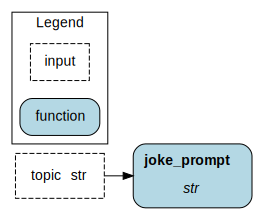

In [4]:
%%cell_to_module joke -d
def joke_prompt(topic: str) -> str:
    return f"Tell me a short joke about {topic}"

The module name allows to namespace functions 

In [5]:
print(joke.joke_prompt(topic="hello"))
print(joke_prompt(topic="greetings"))

Tell me a short joke about hello
Tell me a short joke about greetings


### 2.2 Module imports
Code found in cells with `%%cell_to_module` is treated like an isolated `.py` file. This means you need to define Python imports in the cell itself. 

In [6]:
%%cell_to_module joke
from typing import Optional  # remove to get `NameError: name 'Optional' is not defined``

def joke_prompt(topic: Optional[str] = None) -> str:
    return f"Tell me a short joke about {topic}"

### 2.3 Display module
You can visualize with the `--display / -d` argument. It can receive a dictionary of [visualization `kwargs`](https://hamilton.dagworks.io/en/latest/reference/drivers/Driver/#hamilton.driver.Driver.display_all_functions).

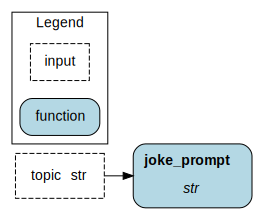

In [7]:
%%cell_to_module joke --display
def joke_prompt(topic: str) -> str:
    return f"Tell me a short joke about {topic}"

In [8]:
display_config = dict(orient="TB")  # orient visualization top to bottom

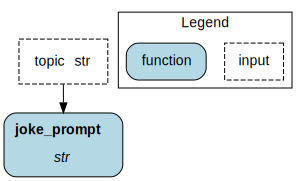

In [9]:
%%cell_to_module joke --display display_config
def joke_prompt(topic: str) -> str:
    return f"Tell me a short joke about {topic}"

### 2.4 Write module to file
To make the transition from notebook to module easy and avoid copy-pasting, you can use `--write_to_file / -w`. This will copy the content of the file to `{MODULE_NAME}.py`. You can also specify a destination file path explicitly.

> ⛔ Be careful with overwriting files with this command. Use git to version your files.

After the running the next cell, you should see `joke.py` generated in your directory.

In [10]:
%%cell_to_module joke --write_to_file
def joke_prompt(topic: str) -> str:
    return f"Knock, knock. Who's there? {topic}"

In [11]:
import joke
joke.joke_prompt("Cowsays")

"Knock, knock. Who's there? Cowsays"

### 2.5 Configure the `Driver`
When using the `@config` function modifiers, you might need to pass a configuration to properly build your dataflow. You can do this inline with the `-c/--config` argument. It supports 3 different format:

1. **Variable name** `--config my_config` where `my_config` is a variable e.g., `my_config=dict(a=True, b=-1)`
2. **Key-value** `--config a=True, b=-1` evaluates to `dict(a="True", b="-1")` since everything is interpreted as strings.
3. **JSON** `--config '{"a": true, "b": -1}'` evaluates to `dict(a=True, b=-1)`. For valid JSON, you need double quotes `"` inside and have single quotes `'` outside.

Here are examples. Notice how the config is properly displayed.

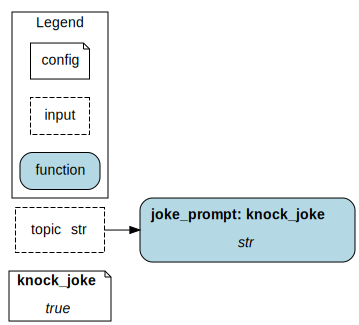

In [ ]:
%%cell_to_module joke --display --config '{"knock_joke": "true"}'
from hamilton.function_modifiers import config

@config.when(knock_joke="true")
def joke_prompt__knock(topic: str) -> str:
    return f"Knock, knock. Who's there? {topic}"

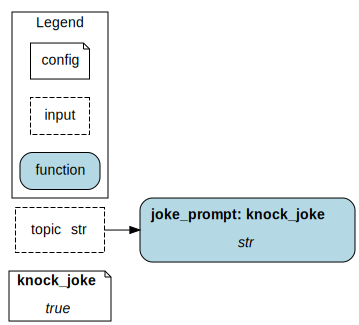

In [13]:
%%cell_to_module joke --display --config knock_joke=true
from hamilton.function_modifiers import config

@config.when(knock_joke="true")
def joke_prompt__knock(topic: str) -> str:
    return f"Knock, knock. Who's there? {topic}"

In [14]:
my_config = dict(knock_joke="true")

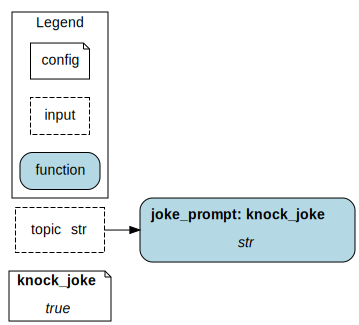

In [15]:
%%cell_to_module joke --display --config my_config
from hamilton.function_modifiers import config

@config.when(knock_joke="true")
def joke_prompt__knock(topic: str) -> str:
    return f"Knock, knock. Who's there? {topic}"

### 2.6 Build a `Driver`

The `Driver` definition can be required to properly build some Hamilton dataflow, in particular those using `.with_config() / @config` and `Parallelizable[]/Collect[]`. We can pass a `Builder` object using `-b/--builder`.

Here are examples. Notice how the config from the `Builder` is properly displayed.

In [16]:
my_builder = (
    driver.Builder()
    .enable_dynamic_execution(allow_experimental_mode=True)
    .with_config({"knock_joke": "true"})
)

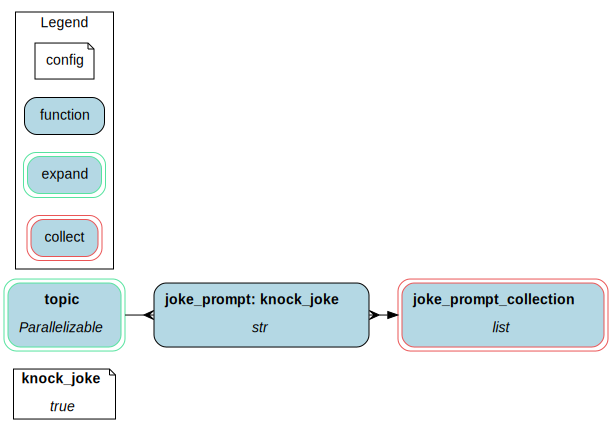

In [17]:
%%cell_to_module joke --display -b my_builder
from hamilton.htypes import Parallelizable, Collect
from hamilton.function_modifiers import config

def topic() -> Parallelizable[str]:
    for t in ["Tom", "Jerry"]:
        yield t

@config.when(knock_joke="true")
def joke_prompt__knock(topic: str) -> str:
    return f"Knock, knock. Who's there? {topic}"

def joke_prompt_collection(joke_prompt: Collect[str]) -> list:
    return list(joke_prompt)

### 2.7 Load external modules
While developing your dataflow with `%%cell_to_module`, you might want to load nodes from another Python module. To do, simply import it and add it to the `Driver` using `.with_modules()` 

In [18]:
my_builder = driver.Builder().with_modules(joke)

The nodes `topic` and `joke_prompt` origin from `joke.py`

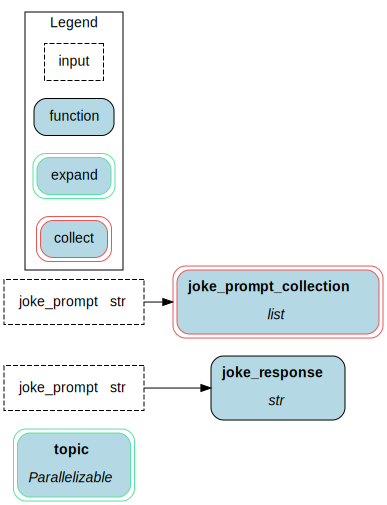

In [19]:
%%cell_to_module reply --display --builder my_builder
def joke_response(joke_prompt: str) -> str:
    return f"{joke_prompt}\n\nCowsay who?"

### 2.8 Edit external modules
It is also possible to load the content of a Python module into a notebook cell to be able to edit it interactively!

This is essentially the reverse operation of `%%cell_to_module` hence why it's called `%module_to_cell`. This is a line magic (single `%`) and it reads the content of the line as a file path to a `.py` file.

In [20]:
# execute this to generate a new cell
%module_to_cell ./joke.py

In [ ]:
%%cell_to_module joke
def joke_prompt(topic: str) -> str:
    return f"Knock, knock. Who's there? {topic}"


If you executed the previous cell, a new code cell was created above with the content of `joke.py`. You can add `--write_to_file` to write the notebook cell back to the file.

## 3. Execute a dataflow
One of the best part about notebooks is the ability to execute and immediately inspect results. They provide a "read-eval-print" loop (REPL) coding experience. With this extension, you can use a single notebook cell to define and execute your dataflow for a tight feedback loop.

If you're familiar with Hamilton, you probably figured out that you can build a `Driver` from the dynamically defined modules (like the next cell). But we have better interactive options!

In [21]:
dr = driver.Builder().with_modules(joke).build()
results = dr.execute(["joke_prompt"], inputs=dict(topic="Cowsay"))
results

{'joke_prompt': None}

### 3.1 Execute cell
By adding `--execute / -x` to your module definition, the defined dataflow will be executed using `Driver.execute()` with all available nodes.

The `--display` visualization should now include **output** nodes reflecting the executed nodes.

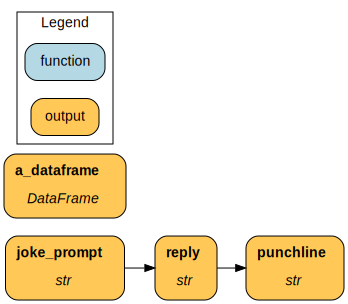

In [22]:
%%cell_to_module joke --display --execute
import pandas as pd

def joke_prompt() -> str:
    return f"Knock, knock. Who's there? Cowsay"

def reply(joke_prompt: str) -> str:
    _, _, right = joke_prompt.partition("? ")
    return f"{right} who?"

def punchline(reply: str) -> str:
    left, _, _ = reply.partition(" ")
    return f"No, {left} MooOOooo"

def a_dataframe() -> pd.DataFrame:
    return pd.DataFrame({"a": [0, 1, 2, 3], "b": ["a", "b", "c", "d"]})

Adding the flag `--show_results` will print node results to the cell output after each execution.

In [23]:
%%cell_to_module joke --execute --inputs docs
import pandas as pd

def joke_prompt() -> str:
    return f"Knock, knock. Who's there? Cowsay"

def reply(joke_prompt: str) -> str:
    _, _, right = joke_prompt.partition("? ")
    return f"{right} who?"

def punchline(reply: str) -> str:
    left, _, _ = reply.partition(" ")
    return f"No, {left} MooOOooo"

def a_dataframe() -> pd.DataFrame:
    return pd.DataFrame({"a": [0, 1, 2, 3], "b": ["a", "b", "c", "d"]})

KeyError: Received `--inputs docs` but variable not found.


### 3.2 Requesting nodes
You can a variable name to `--execute` which specifies the list of nodes to execute. This will be reflected in the visualization.

In [24]:
node_to_execute = ["reply"]

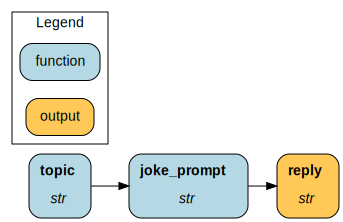

In [25]:
%%cell_to_module joke --display --execute node_to_execute
def topic() -> str:
    return "Cowsay"

def joke_prompt(topic: str) -> str:
    return f"Knock, knock. Who's there? {topic}"

def reply(joke_prompt: str) -> str:
    _, _, right = joke_prompt.partition("? ")
    return f"{right} who?"

def punchline(reply: str) -> str:
    left, _, _ = reply.partition(" ")
    return f"No, {left} MooOOooo"

### 3.3 Inspecting results
Ok, but how do you access results? With the node name! Magic 🧙

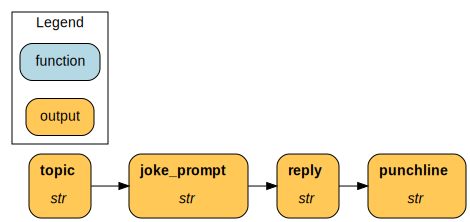

In [26]:
%%cell_to_module joke --display --execute --hide_results
def topic() -> str:
    return "Cowsay"

def joke_prompt(topic: str) -> str:
    return f"Knock, knock. Who's there? {topic}"

def reply(joke_prompt: str) -> str:
    _, _, right = joke_prompt.partition("? ")
    return f"{right} who?"

def punchline(reply: str) -> str:
    left, _, _ = reply.partition(" ")
    return f"No, {left} MooOOooo"

In [27]:
punchline

'No, Cowsay MooOOooo'

The results are assigned to variables matching their node names. This means you can quickly access them by typing their name. In most notebook environment, you get tab-completion for the and can view results in the variable inspector (especially useful for dataframes).

What's the magic trick? 🐰

When executing the cell, we are effectively:
1. Loading it's content as a module
2. Building a `Driver` with this module
3. Executing the module with all nodes
4. Assigning values from the results of `.execute()` to variables

Consequently, functions defined in `%%cell_to_node` are replaced by their "value". You access functions directly through their module:

In [28]:
joke.punchline("Foxey")

'No, Foxey MooOOooo'

### 3.4 Inputs & overrides
In Hamilton, *inputs*  are values external to the dataflow and *overrides* are values to replace the output of a node (it effectively skips upstream operations). You can use `--inputs / -i` and `--outputs / -o` to pass dictionaries of values for execution.

In [29]:
my_inputs = dict(topic="monday")
my_overrides = dict(punchline="Bingo bongo!")

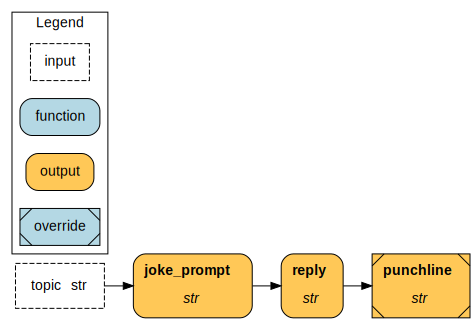

In [30]:
%%cell_to_module joke --display --execute --inputs my_inputs --overrides my_overrides
def joke_prompt(topic: str) -> str:
    return f"Knock, knock. Who's there? {topic}"

def reply(joke_prompt: str) -> str:
    _, _, right = joke_prompt.partition("? ")
    return f"{right} who?"

def punchline(reply: str) -> str:
    left, _, _ = reply.partition(" ")
    return f"No, {left} MooOOooo"

### 3.5 Driver Adapters
You can modify execution by passing adapters to `--builder / -b`. Adapters are flexible tools that can provide a variety of features. For instance, the next few cells uses `PrintLn()` to execution status after each node.

In [31]:
from hamilton.lifecycle.default import PrintLn
my_builder = driver.Builder().with_adapters(PrintLn())  # add the adapter

Notice in the printed statement how the overriden `punchline` node isn't executed.

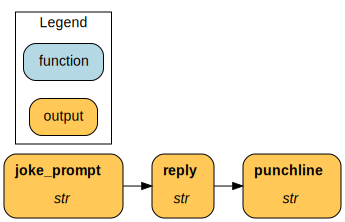

Executing node: joke_prompt.
Finished debugging node: joke_prompt in 80.3μs. Status: Success.
Executing node: reply.
Finished debugging node: reply in 44.8μs. Status: Success.
Executing node: punchline.
Finished debugging node: punchline in 42.7μs. Status: Success.


In [32]:
%%cell_to_module joke --builder my_builder --display --execute 
def joke_prompt() -> str:
    return f"Knock, knock. Who's there? Cowsay"

def reply(joke_prompt: str) -> str:
    _, _, right = joke_prompt.partition("? ")
    return f"{right} who?"

def punchline(reply: str) -> str:
    left, _, _ = reply.partition(" ")
    return f"No, {left} MooOOooo"

There are ton of awesome adapters that can help you with your notebook experience. Here are a few notable mentions:

1. `hamilton.lifecycle.default.PrintLn()` print execution status (this is similar to the `--show_results` flag).
2. `hamilton.plugins.h_tqdm.ProgressBar()` add a progress bar for execution.
3. `hamilton.lifecycle.default.PDBDebugger()` allows you to step into a node with a Python debugger, allowing you to execute code line by line.

Note that all of these adapters work with Hamilton outside notebooks too!

## 3.6 Caching
The next builder include the `.with_cache()` clause. This will store results on disks. Adding the `--display_cache` flag will print a visualization of what results were retrieved from cache once execution is completed.

To view it, execute the cell twice.

In [33]:
builder_with_cache = driver.Builder().with_cache()

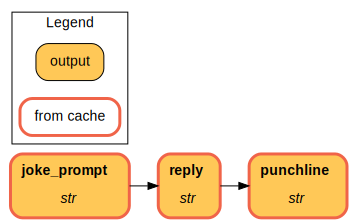

In [34]:
%%cell_to_module joke --builder builder_with_cache --execute --display_cache
def joke_prompt() -> str:
    return f"Knock, knock. Who's there? Cowsay"

def reply(joke_prompt: str) -> str:
    _, _, right = joke_prompt.partition("? ")
    return f"{right} who?"

def punchline(reply: str) -> str:
    left, _, _ = reply.partition(" ")
    return f"No, {left} MooOOooo"